# Miniproyecto 1 - Adquisición de datos y aplicación de técnicas de preprocesamiento para resolver un problema particular
**Autores:**  
* Jackeline Morales Hernandez

* Jose David Ortiz Miranda

**Tratamiento de Señales III**

**Facultad de Ingeniería**

**Universidad de Antioquia**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Librerias Importantes
import scipy.io as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy import signal
from scipy.signal import find_peaks
import scipy.signal as signal
from __future__ import division
from numpy import abs, sum, linspace
from numpy.fft import rfft
import pandas as pd
from scipy.signal import butter, lfilter, filtfilt, sosfilt, find_peaks

In [ ]:
datosP1 = sc.loadmat("/content/drive/My Drive/s14.mat")
datosP2 = sc.loadmat("/content/drive/My Drive/s15.mat")
datosP3 = sc.loadmat("/content/drive/My Drive/s16.mat")
datosP4 = sc.loadmat("/content/drive/My Drive/s17.mat")

In [ ]:
signalsP1 = datosP1['data']
signalsP2 = datosP2['data']
signalsP3 = datosP3['data']
signalsP4 = datosP4['data']
etiquetasP1 = datosP1['labels']
etiquetasP2 = datosP2['labels']
etiquetasP3 = datosP3['labels']
etiquetasP4 = datosP4['labels']
# Esto me arrojará un nd array de n_video * id_signal * Ntimepoints

# 1. Extracción de características

Para extraer las características, se deben recorrer los 40 videos o escenarios de prueba, procesarlos y almacenar el resultado de cada uno como un elemento de una matriz $\boldsymbol{X_{new}} \in {\mathbb{R}}^{N \times D}$ donde N es el número de observaciones (en este caso las realizaciones emocionales), y D es el número de características resultantes en el proceso de extracción.

## 1.1 RESISTENCIA GALVANICA DE LA PIEL (GSR)
### De esta señal extreremos las siguientes caracteristicas:
- Promedio de la resistencia de la piel.
- Número de mínimos locales en la señal GSR.
- Diez potencia espectral en las bandas [0 - 2.4] Hz.

In [ ]:
def Caracteristicas_GSR(signals):
  GSR_Total = []
  for i in range(40):
      GSR = signals[i,36,:]
      #------------------ PROMEDIO --------------------------------------------------------
      GSR_promedio=np.mean(GSR)
      GSR_Total.append(GSR_promedio)
      #------------------ MINIMOS LOCALES  --------------------------------------------------------
      GSR_num_min,_=find_peaks(-GSR, distance = 128)
      min_locales = len(GSR_num_min)
      GSR_Total.append(min_locales)
      # Definir los parámetros del filtro pasa banda (0.0-2.4 Hz)
      #------------------ ESPECTRO DE POTENCIA  --------------------------------------------------------
      freq_min = 0.0001
      freq_max = 2.4
      freq_min_nor = freq_min / 128
      freq_max_nor = freq_max / 128
      # Diseñar el filtro pasa banda
      sos = butter(N=4, Wn=[freq_min_nor, freq_max_nor], btype='band',output = 'sos')
      # Aplicar el filtro pasa banda a la señal de GSR
      GSR_filtrada = sosfilt(sos, GSR) # Inicializar la matriz filtrada
      # Calcular la FFT de la señal filtrada
      fft_resultado = np.fft.fft(GSR_filtrada)
      frecuencias = np.fft.fftfreq(len(fft_resultado), 1/128)

      # Calcula las potencias espectrales en la banda de 0 a 2.4 Hz
      potencias_banda = np.abs(fft_resultado)**2
      # Toma las 10 primeras potencias
      diez_potencias = np.argsort(potencias_banda)[::-1][:10]
      top_10_potencias = potencias_banda[diez_potencias]
      GSR_Total.append(top_10_potencias)
      diez_freq = frecuencias[diez_potencias]
      GSR_Total.append(diez_freq)
      #Crea un nuevo vector para ordenar todos sus datos
  GSR_signal = []

    # Recorre los elementos del vector original y agrega los valores a nuevo_vector
  for elemento in GSR_Total:
      if isinstance(elemento, (int, float)):
            # Si es un número, agrégalo directamente a nuevo_vector
          GSR_signal.append(elemento)
      elif isinstance(elemento, tuple) and len(elemento) == 2:
            # Si es una tupla con 2 elementos, convierte los elementos a listas y agrega a nuevo_vector
          GSR_signal.extend(list(elemento[0]))
          GSR_signal.extend(list(elemento[1]))
      elif isinstance(elemento, np.ndarray) and elemento.ndim == 1:
            # Si es un array de una dimensión, conviértelo a lista y agrégalo a nuevo_vector
          GSR_signal.extend(elemento.tolist())

    # Ahora, nuevo_vector contendrá los datos organizados en una lista plana
  GSR_signal = np.array(GSR_signal).reshape(-1)
  GSR_signal=np.array(GSR_signal).reshape(40,22)
  return GSR_signal

### Caracteristicas GSR para las 4 personas

In [ ]:
GSR_P1=Caracteristicas_GSR(signalsP1)
GSR_P2=Caracteristicas_GSR(signalsP2)
GSR_P3=Caracteristicas_GSR(signalsP3)
GSR_P4=Caracteristicas_GSR(signalsP4)

### 1.2 PLETISMOGRAFIA O VOLUMEN DE LA PRESION SANGUINEA
### De esta señal extreremos las siguientes caracteristicas:
- Media y desviación estándar de la frecuencia cardiaca.
- Espectro de potencia en las bandas de 0.2 a 0.3 Hz.
- La variabilidad de la frecuencia cardíaca HRV

In [ ]:
def Caracteristicas_Pleth(signals):
  pleth_Total = []
  for i in range(40):
    pleth = signals[i,38,:]
    #------------------ MEDIA --------------------------------------------------------
    pleth_media=np.mean(pleth)
    pleth_Total.append(pleth_media)
    #------------------ DESVIACION ESTANDAR --------------------------------------------------------
    pleth_std_des=np.std(pleth)
    pleth_Total.append(pleth_std_des)
    #------------------ ESPECTRO DE POTENCIA --------------------------------------------------------
    # Definir los parámetros del filtro pasa banda (0.2-0.3 Hz)
    freq_min = 0.2
    freq_max = 0.3
    freq_min_nor = freq_min / 128
    freq_max_nor = freq_max / 128
    # Diseñar el filtro pasa banda
    sos = butter(N=4, Wn=[freq_min_nor, freq_max_nor], btype='band',output = 'sos')
    # Aplicar el filtro pasa banda a la señal de GSR
    pleth_filtrada = sosfilt(sos, pleth) # Inicializar la matriz filtrada
    # Calcular la FFT de la señal filtrada
    fft_resultado = np.fft.fft(pleth_filtrada)
    #freq_pleth = np.fft.fftfreq(len(fft_resultado), 1/128)

    # Calcula las potencias espectrales en la banda de 0.2 a 0.3 Hz
    potencias_pleth = np.abs(fft_resultado)**2
    potencias_pleth_prom=np.mean(potencias_pleth)
    pleth_Total.append(potencias_pleth_prom)
  #------------------ HRV --------------------------------------------------------
    t = np.arange(0, len(pleth)) * (1 / 128)
    rr_peaks, _ = find_peaks(pleth,distance=128)
    R_loc_time=rr_peaks / 128
    HRV=np.diff(R_loc_time)
    HRV_prom=np.mean(HRV)
    pleth_Total.append(HRV_prom)

  pleth_Total=np.array(pleth_Total).reshape(40,4)
  return pleth_Total

### Caracteristicas pletismografia para las 4 personas

In [ ]:
pleth_P1=Caracteristicas_Pleth(signalsP1)
pleth_P2=Caracteristicas_Pleth(signalsP2)
pleth_P3=Caracteristicas_Pleth(signalsP3)
pleth_P4=Caracteristicas_Pleth(signalsP4)

## 1.3 PATRON DE RESPIRACIÓN
### De esta señal extreremos las siguientes caracteristicas:
- Tasa respiratoria.
- Media de la derivada (variación de la señal de respiración).
- Ritmo respiratorio (centroide espectral).

In [ ]:
def Caracteristicas_respiration(signals):
  respiration_Total=[]
  for i in range(40):
    respiration = signals[i,37,:]
    #------------------ TASA RESPIRATORIA --------------------------------------------------------
    peaks, _ = signal.find_peaks(respiration, distance=128)  # Ajusta el umbral según tus datos
    t_respiration = np.diff(peaks)/128  # Calcula la duración entre picos
    respiration_rate = 60 / np.mean(t_respiration)
    respiration_Total.append(respiration_rate)
    #------------------ MEDIA DE LA DERIVADA --------------------------------------------------------
    respiration_derivada=np.gradient(respiration)
    respiration_derivada_promedio = np.mean(respiration_derivada)
    respiration_Total.append(respiration_derivada_promedio)
    #------------------ RITMO RESPIRATORIO --------------------------------------------------------
    espectro_respiration = abs(rfft(respiration))
    espectro_respiration_normalizado = espectro_respiration / sum(espectro_respiration)
    frecuencias_normalizadas = linspace(0, 1, len(espectro_respiration))
    espectro_central = sum(frecuencias_normalizadas * espectro_respiration_normalizado)
    respiration_Total.append(espectro_central)

  respiration_Total=np.array(respiration_Total).reshape(40,3)
  return respiration_Total

### Caracteristicas respiración para las 4 personas

In [ ]:
respiration_P1=Caracteristicas_respiration(signalsP1)
respiration_P2=Caracteristicas_respiration(signalsP2)
respiration_P3=Caracteristicas_respiration(signalsP3)
respiration_P4=Caracteristicas_respiration(signalsP4)

## 1.4 TEMPERATURA DE LA PIEL
### De esta señal extreremos las siguientes caracteristicas:
- Promedio de la señal de temperatura de la piel.
- Promedio de la derivada.
- Potencia espectral en las bandas ([0.1-0.2]Hz)

In [ ]:
def Caracteristicas_temp(signals):
  Temperatura_Total = []
  for i in range(40):
      temp = signals[i,39,:]
      #------------------ PROMEDIO --------------------------------------------------------
      temp_media=np.mean(temp)
      Temperatura_Total.append(temp_media)
      #------------------ PROMEDIO DE LA DERIVADA --------------------------------------------------------
      temp_derivada=np.gradient(temp)
      temp_derivada_promedio = np.mean(temp_derivada)
      Temperatura_Total.append(temp_derivada_promedio)
      #------------------ PROMEDIO --------------------------------------------------------
      # Definir los parámetros del filtro pasa banda (0.1-0.1Hz)
      freq_min = 0.1
      freq_max = 0.2
      freq_min_nor = freq_min / 128
      freq_max_nor = freq_max / 128
      # Diseñar el filtro pasa banda
      sos = butter(N=4, Wn=[freq_min_nor, freq_max_nor], btype='band',output = 'sos')
      # Aplicar el filtro pasa banda a la señal de GSR
      Temperatura_filtrada = sosfilt(sos, temp) # Inicializar la matriz filtrada
      # Calcular la FFT de la señal filtrada
      fft_resultado = np.fft.fft(Temperatura_filtrada)
      frecuencias = np.fft.fftfreq(len(fft_resultado), 1/128)

      # Calcula las potencias espectrales en la banda de 0 a 2.4 Hz
      potencias_temp = np.abs(fft_resultado)**2
      potencias_temp_prom=np.mean(potencias_temp)
      Temperatura_Total.append(potencias_temp_prom)
  Temperatura_Total=np.array(Temperatura_Total).reshape(40,3)
  return Temperatura_Total

### Caracteristicas temperatura para las 4 personas

In [ ]:
temp_P1=Caracteristicas_temp(signalsP1)
temp_P2=Caracteristicas_temp(signalsP2)
temp_P3=Caracteristicas_temp(signalsP3)
temp_P4=Caracteristicas_temp(signalsP4)

## 1.5 Electrooculograma (EOG)

### De esta señal extreremos las siguientes caracteristicas:
- Tasa de parpadeo de los ojos.
- Energía de la señal.
- Media y varianza de la señal.

In [ ]:
def Caracteristicas_EOG(signals):
  EOG_Total=[]
  for i in range(40):
      hEOG = signals[i,32,:]
      vEOG = signals[i,33,:]
      energiaH = np.sum(np.abs(hEOG) ** 2)
      EOG_Total.append(energiaH)
      energiaV = np.sum(np.abs(vEOG) ** 2)
      EOG_Total.append(energiaV)
      hEOG_media=np.mean(hEOG)
      EOG_Total.append(hEOG_media)
      vEOG_media=np.mean(vEOG)
      EOG_Total.append(vEOG_media)
      hEOG_var=np.var(hEOG)
      EOG_Total.append(hEOG_var)
      vEOG_var=np.var(vEOG)
      EOG_Total.append(vEOG_var)
      fft_resultado_vEOG = np.fft.fft(vEOG)
      frecuencias = np.fft.fftfreq(len(vEOG))
      picos, _ = find_peaks(np.abs(fft_resultado_vEOG), distance=128)
      tasa_de_parpadeo = len(picos) / (len(vEOG) / 128) * 60
      EOG_Total.append(tasa_de_parpadeo)
  EOG_Total=np.array(EOG_Total).reshape(40,7)
  return EOG_Total

### Caracteristicas EOG para las 4 personas

In [ ]:
EOG_P1=Caracteristicas_EOG(signalsP1)
EOG_P2=Caracteristicas_EOG(signalsP2)
EOG_P3=Caracteristicas_EOG(signalsP3)
EOG_P4=Caracteristicas_EOG(signalsP4)

### 1.6 Señales Electromiográficas (EMG)

### De esta señal extreremos las siguientes caracteristicas:
- Energia de cada señal.
- Media y varianza de cada señal.


In [ ]:
def Caracteristicas_EMG(signals):
  EMG_Total = []
  for i in range(40):
      zEMG = signals[i,34,:]
      tEMG = signals[i,35,:]
      energiazEMG = np.sum(np.abs(zEMG) ** 2)
      EMG_Total.append(energiazEMG)
      energiatEMG = np.sum(np.abs(tEMG) ** 2)
      EMG_Total.append(energiatEMG)
      zEMG_media=np.mean(zEMG)
      EMG_Total.append(zEMG_media)
      tEMG_media=np.mean(tEMG)
      EMG_Total.append(tEMG_media)
      zEMG_var=np.var(zEMG)
      EMG_Total.append(zEMG_var)
      tEMG_var=np.var(tEMG)
      EMG_Total.append(tEMG_var)
  EMG_Total=np.array(EMG_Total).reshape(40,6)
  return EMG_Total

### Caracteristicas EMG para las 4 personas

In [ ]:
EMG_P1=Caracteristicas_EMG(signalsP1)
EMG_P2=Caracteristicas_EMG(signalsP2)
EMG_P3=Caracteristicas_EMG(signalsP3)
EMG_P4=Caracteristicas_EMG(signalsP4)

### 1.7 Electroencefalograma (EEG)



*  Espectro de potencia Alpha
*  Espectro de potencia Beta
*  Espectro de potencia Gamma




### 1.7.1 Espectro de potencia

In [ ]:
def Caracteristicas_EEG(signals,freq_min,freq_max):
  EEG_Total = []
  for i in range(40):
      Alpha_C3 = signals[i,6,:] #electrodo C3
      Alpha_C4 = signals[i,24,:] #electrodo C4
      # Definir los parámetros del filtro pasa banda para las Alpha (8-12Hz)
      freq_min_nor = freq_min / 128
      freq_max_nor = freq_max / 128
      # Diseñar el filtro pasa banda
      sos = butter(N=4, Wn=[freq_min_nor, freq_max_nor], btype='band',output = 'sos')
      # Aplicar el filtro pasa banda a la señal de GSR
      Alpha_C3_filtrada = sosfilt(sos,Alpha_C3) # Inicializar la matriz filtrada
      Alpha_C4_filtrada = sosfilt(sos,Alpha_C4)

      fft_resultado_C3= np.fft.fft(Alpha_C3_filtrada)
      fft_resultado_C4= np.fft.fft(Alpha_C4_filtrada)

      frecuencias_C3 = np.fft.fftfreq(len(fft_resultado_C3), 1/128)
      frecuencias_C4 = np.fft.fftfreq(len(fft_resultado_C4), 1/128)
      # Calcula las potencias espectrales en la banda de 8 a 12 Hz
      pot_C3 = np.abs(fft_resultado_C3)**2
      pot_C4=np.abs(fft_resultado_C4)**2

      potencias_C3_prom=np.mean(pot_C3)
      potencias_C4_prom=np.mean(pot_C4)
      EEG_Total.append(potencias_C3_prom)
      EEG_Total .append(potencias_C4_prom)
  EEG_Total =np.array(EEG_Total ).reshape(40,2)
  return EEG_Total

### Caracteristicas EEG para las 4 personas

In [ ]:
EEG_Alpha_P1=Caracteristicas_EEG(signalsP1,8,12)
EEG_Beta_P1=Caracteristicas_EEG(signalsP1,12,30)
EEG_Gamma_P1=Caracteristicas_EEG(signalsP1,30,100)

EEG_Alpha_P2=Caracteristicas_EEG(signalsP2,8,12)
EEG_Beta_P2=Caracteristicas_EEG(signalsP2,12,30)
EEG_Gamma_P2=Caracteristicas_EEG(signalsP2,30,100)

EEG_Alpha_P3=Caracteristicas_EEG(signalsP3,8,12)
EEG_Beta_P3=Caracteristicas_EEG(signalsP3,12,30)
EEG_Gamma_P3=Caracteristicas_EEG(signalsP3,30,100)

EEG_Alpha_P4=Caracteristicas_EEG(signalsP4,8,12)
EEG_Beta_P4=Caracteristicas_EEG(signalsP4,12,30)
EEG_Gamma_P4=Caracteristicas_EEG(signalsP4,30,100)



## Emociones

In [ ]:
def data_emocion(etiquetas):
  arousal = etiquetas[:,1]
  valence = etiquetas[:,0]
  emocion = np.zeros(np.size(arousal))
  emocion[valence<=4] = 0
  emocion[np.logical_and(valence>4 ,valence<=7)] = 1
  emocion[valence>7] = 2
  return emocion

## Creación del DataFream

In [ ]:
def caracterizadorDEAP(GSR_signal,pleth_Total,respiration_Total,Temperatura_Total,EOG_Total,EMG_Total,EEG_Total_Alpha,EEG_Total_Beta,EEG_Total_Gamma): #funcion donde caracteriza y concardena los vectores

    xTrial = np.hstack((GSR_signal,pleth_Total,respiration_Total,Temperatura_Total,EOG_Total,EMG_Total,EEG_Total_Alpha,EEG_Total_Beta,EEG_Total_Gamma))
    return xTrial

# Llama a la función caracterizadorDEAP con nuevo_vector
xTrialP1 = caracterizadorDEAP(GSR_P1,pleth_P1,respiration_P1,temp_P1,EOG_P1,EMG_P1,EEG_Alpha_P1,EEG_Beta_P1,EEG_Gamma_P1)
xTrialP2 = caracterizadorDEAP(GSR_P2,pleth_P2,respiration_P2,temp_P2,EOG_P2,EMG_P2,EEG_Alpha_P2,EEG_Beta_P2,EEG_Gamma_P2)
xTrialP3 = caracterizadorDEAP(GSR_P3,pleth_P3,respiration_P3,temp_P3,EOG_P3,EMG_P3,EEG_Alpha_P3,EEG_Beta_P3,EEG_Gamma_P3)
xTrialP4 = caracterizadorDEAP(GSR_P4,pleth_P4,respiration_P4,temp_P4,EOG_P4,EMG_P4,EEG_Alpha_P4,EEG_Beta_P4,EEG_Gamma_P4)
#Se crea el dataFrame
dataFrame_P1 = pd.DataFrame(xTrialP1)
dataFrame_P1['Emocion'] = data_emocion(etiquetasP1)

dataFrame_P2 = pd.DataFrame(xTrialP2)
dataFrame_P2['Emocion'] = data_emocion(etiquetasP2)

dataFrame_P3 = pd.DataFrame(xTrialP3)
dataFrame_P3['Emocion'] = data_emocion(etiquetasP3)

dataFrame_P4 = pd.DataFrame(xTrialP4)
dataFrame_P4['Emocion'] = data_emocion(etiquetasP4)

dataFrame_Total=pd.concat([dataFrame_P1,dataFrame_P2,dataFrame_P3,dataFrame_P4])
# Cambiar nombres de las columnas usando rename
nuevos_nombres = ['Promedio GSR','Minimos locales GSR','Pot 1 GSR ','Pot 2 GSR ','Pot 3 GSR ','Pot 4 GSR ','Pot 5 GSR ','Pot 6 GSR ','Pot 7 GSR ','Pot 8 GSR ','Pot 9 GSR ','Pot 10 GSR ','Freq 1 GSR ','Freq 2 GSR ','Freq 3 GSR ','Freq 4 GSR ','Freq 5 GSR ','Freq 6 GSR ','Freq 7 GSR ','Freq 8 GSR ','Freq 9 GSR ','Freq 10 GSR ','Media Pleth','Desviacion Estandar Pleth','Pot Pleth', 'HRV [seg]','Tasa Respiracion','Media Derivada Respiracion','Ritmo Respiracion','Promedio Temperatura','Promedio Derivada Temperatura','Potencia Espectral Temperatura','Energia hEOG','Energia vEOg','Media hEOG','Media vEOG','Varianza hEOG','Varianza vEOG','Tasa de parpadeo vEOG','Energia zEMG','Energia tEMG','Media zEMG','Media tEMG','Varianza zEMG','Varianza tEMG','Potencia Alpha EEG C3','Potencia Alpha EEG C4','Potencia Beta EEG C3','Potencia Beta EEG C4','Potencia Gamma EEG C3','Potencia Gamma EEG C4','Emocion']
dataFrame_Total.columns = nuevos_nombres
dataFrame_Total = dataFrame_Total.reset_index()
dataFrame_Total

,index,Promedio GSR,Minimos locales GSR,Pot 1 GSR,Pot 2 GSR,Pot 3 GSR,Pot 4 GSR,Pot 5 GSR,Pot 6 GSR,Pot 7 GSR,...,Media tEMG,Varianza zEMG,Varianza tEMG,Potencia Alpha EEG C3,Potencia Alpha EEG C4,Potencia Beta EEG C3,Potencia Beta EEG C4,Potencia Gamma EEG C3,Potencia Gamma EEG C4,Emocion
0,0,-18005.683435,13.0,1.288732e+16,1.772414e+15,1.772414e+15,1.277566e+15,1.277566e+15,2.953486e+14,2.953486e+14,...,-190.805355,38807.705457,64728.585821,1.360796e+05,3.114207e+05,243901.251741,3.041091e+05,225125.095796,323180.418261,2.0
1,1,-8794.650746,16.0,3.088293e+15,9.539942e+14,9.539942e+14,3.975770e+14,3.975770e+14,8.871423e+13,8.871423e+13,...,67.826224,3190.799300,14631.755595,2.238600e+05,3.913786e+05,268781.582813,3.567027e+05,92651.319062,125603.999163,1.0
2,2,-1331.408630,19.0,1.058006e+14,1.058006e+14,7.315040e+13,1.053249e+13,1.053249e+13,2.117346e+12,2.117346e+12,...,-102.751395,8635.302077,19001.371419,1.553689e+05,3.814045e+05,225173.138136,3.421276e+05,145681.251887,171245.756219,2.0
3,3,3491.283824,15.0,4.960742e+14,1.930184e+14,1.930184e+14,3.658948e+13,3.658948e+13,2.216112e+13,2.216112e+13,...,248.048183,737.418995,39808.699543,2.100546e+05,4.018904e+05,305280.857258,4.118029e+05,135676.544125,165135.677181,2.0
4,4,-3736.386024,23.0,5.624871e+14,1.634305e+14,1.634305e+14,2.865608e+13,2.865608e+13,2.051458e+13,2.051458e+13,...,-414.961066,5016.463580,262354.178870,1.013400e+06,1.997528e+06,569395.091262,1.055192e+06,92071.695049,140242.223288,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,35,5204.994820,24.0,1.091853e+15,3.439172e+13,3.439172e+13,1.757257e+13,1.757257e+13,9.686179e+12,9.686179e+12,...,272.747337,787.882707,19220.126678,3.771309e+04,2.155863e+04,86237.242295,7.303827e+04,59882.809936,34262.413650,0.0
156,36,2975.633960,30.0,3.552287e+14,1.790330e+14,1.790330e+14,1.185616e+13,1.185616e+13,1.136667e+13,1.136667e+13,...,184.217395,319.067831,1614.527689,4.293294e+04,2.598279e+04,71951.421629,5.836870e+04,39870.496034,29528.838134,0.0
157,37,7866.527529,35.0,2.494527e+15,3.151856e+14,3.151856e+14,5.141049e+13,5.141049e+13,1.957428e+13,1.957428e+13,...,108.425739,10932.180354,4785.282682,4.049473e+04,3.100939e+04,86000.153746,5.501708e+04,61048.170959,35180.448520,0.0
158,38,-2334.049943,31.0,2.213637e+14,2.053189e+13,2.053189e+13,7.743863e+12,7.743863e+12,6.873822e+12,6.873822e+12,...,-353.986459,7391.494772,103070.804983,4.097852e+04,3.040401e+04,76221.488996,4.768716e+04,109988.890021,33162.719749,2.0


## Pairplots

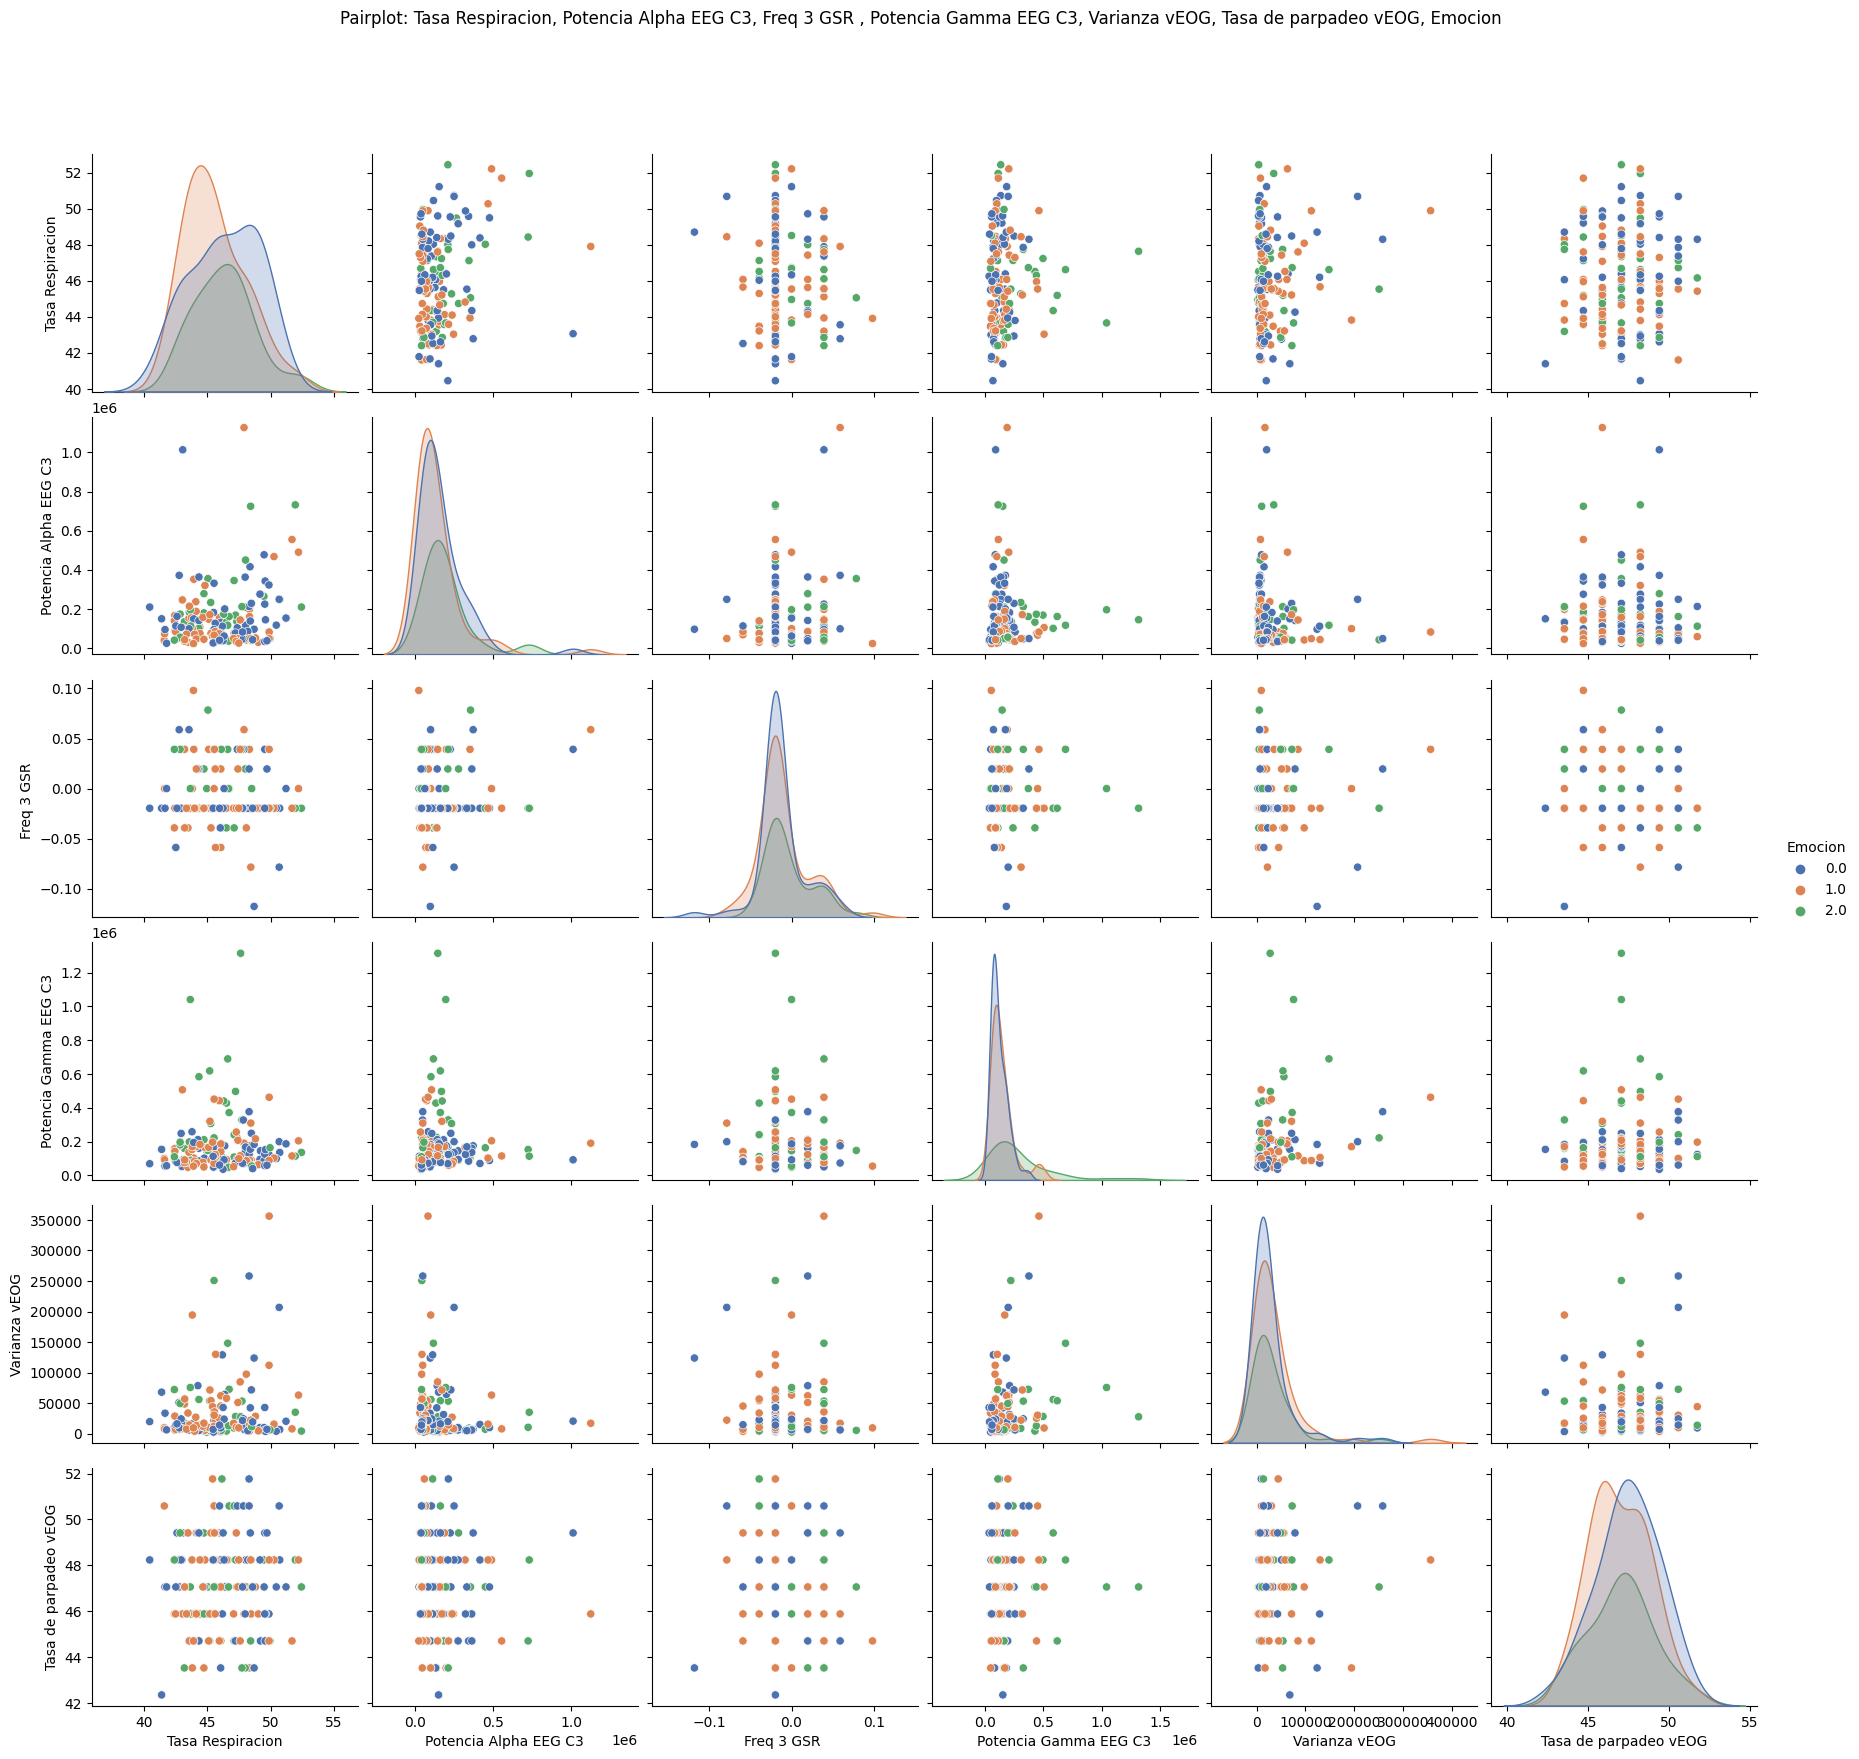

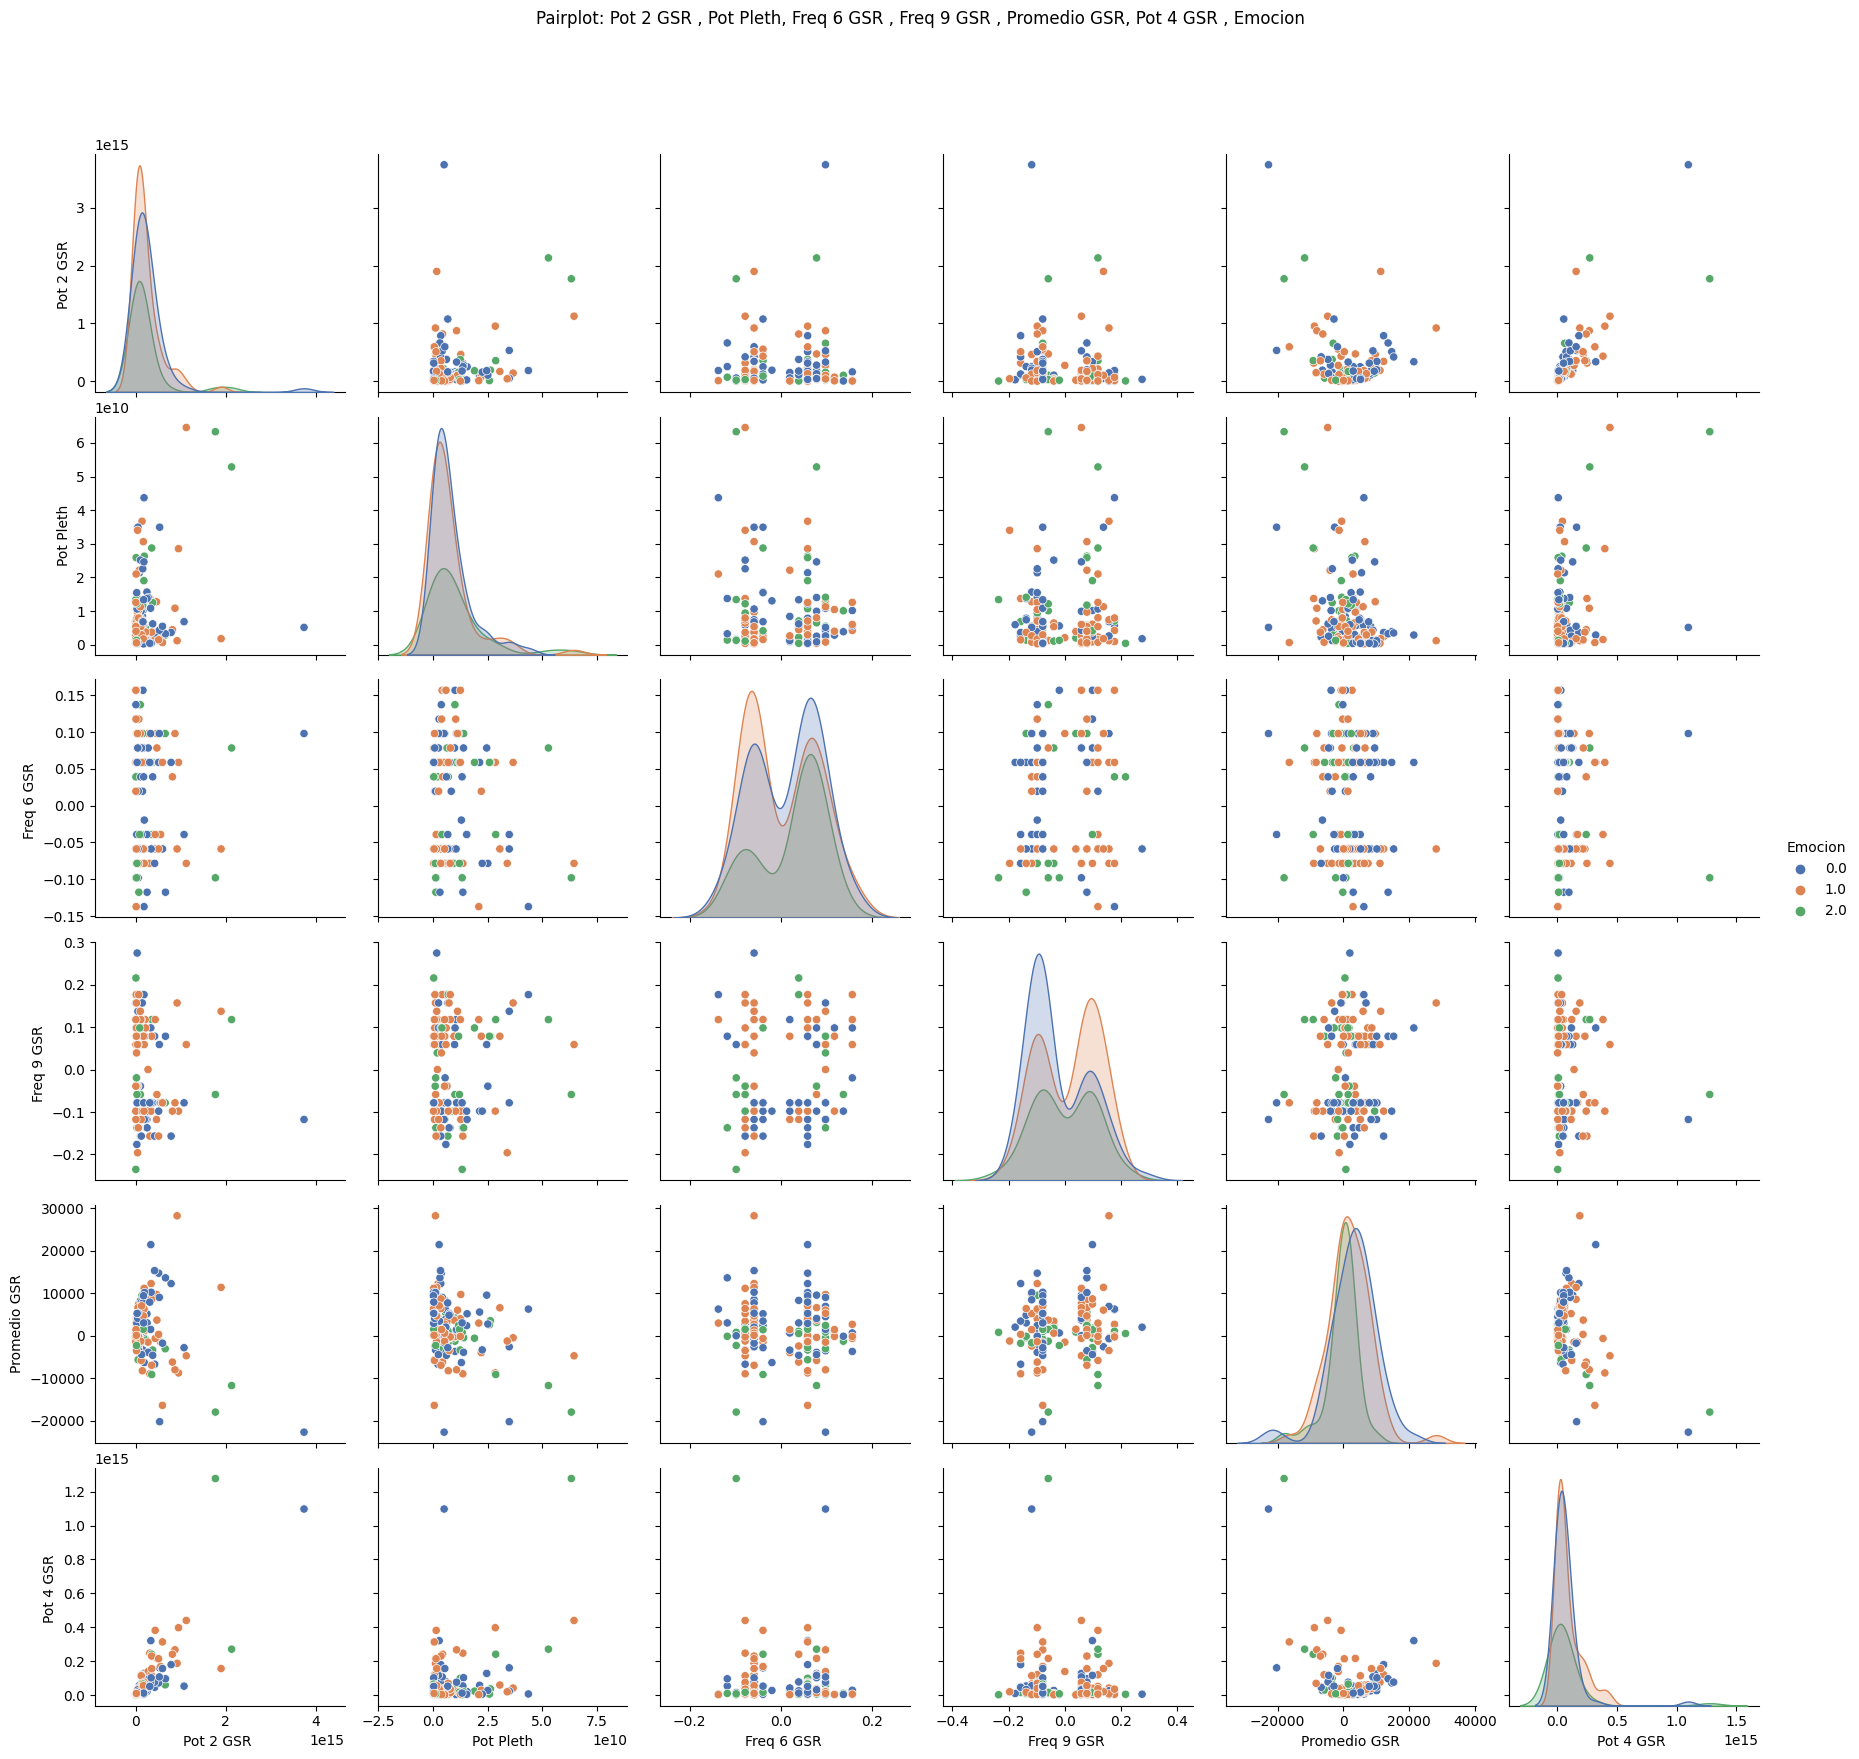

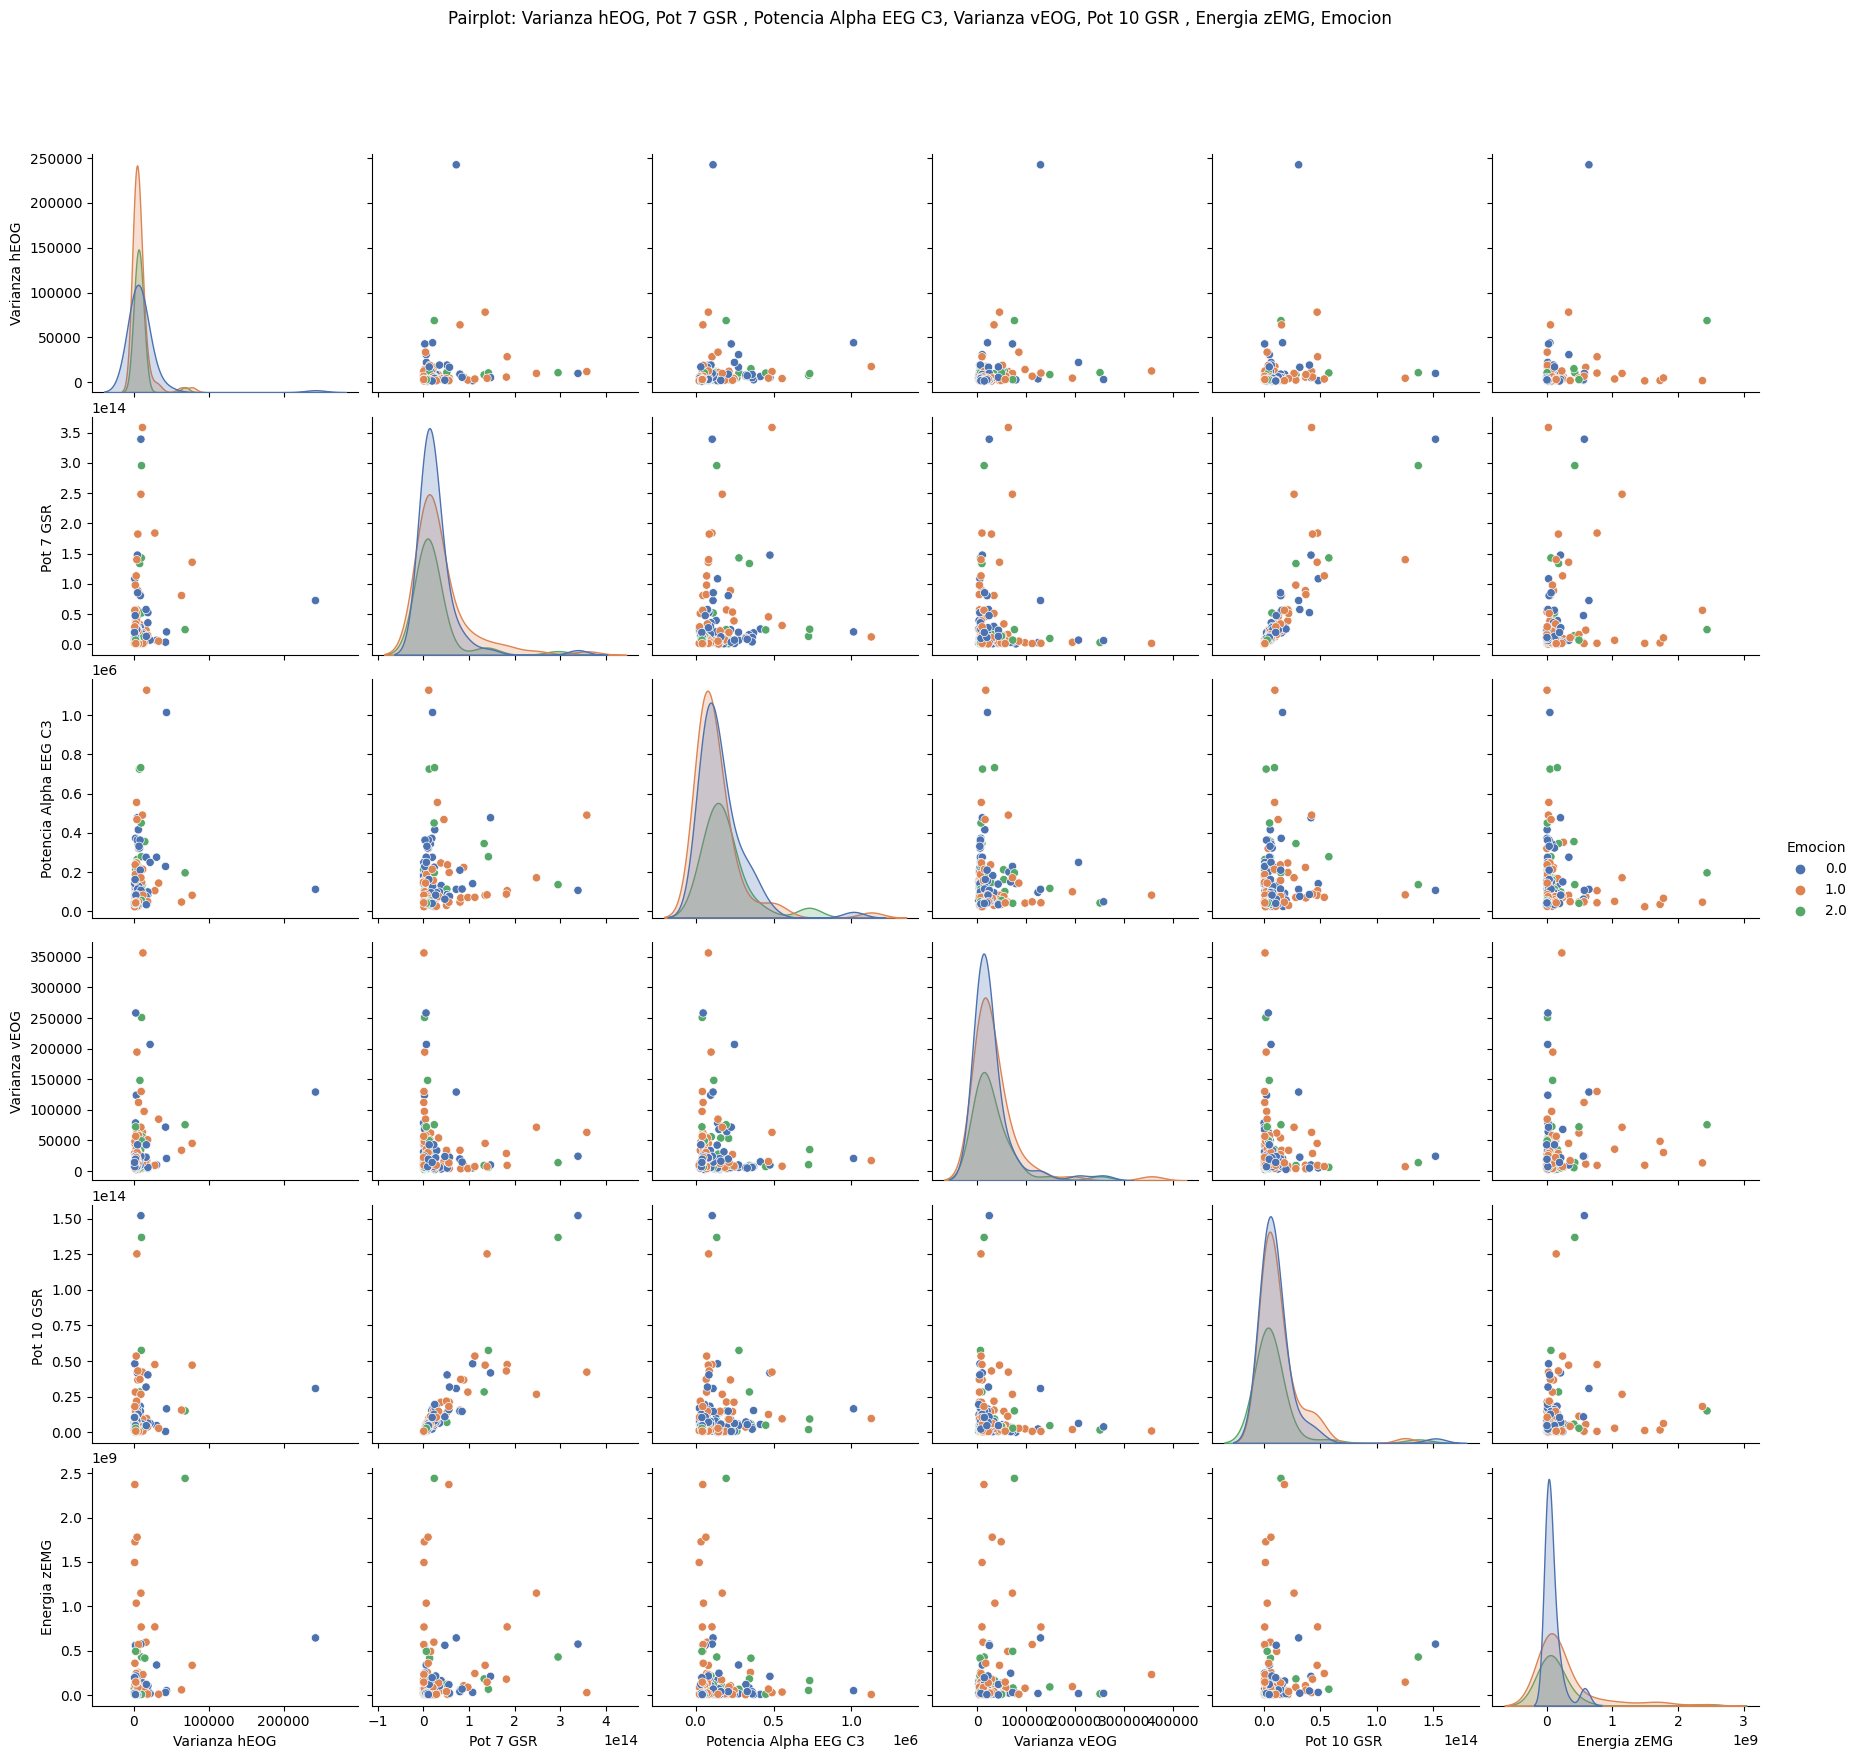

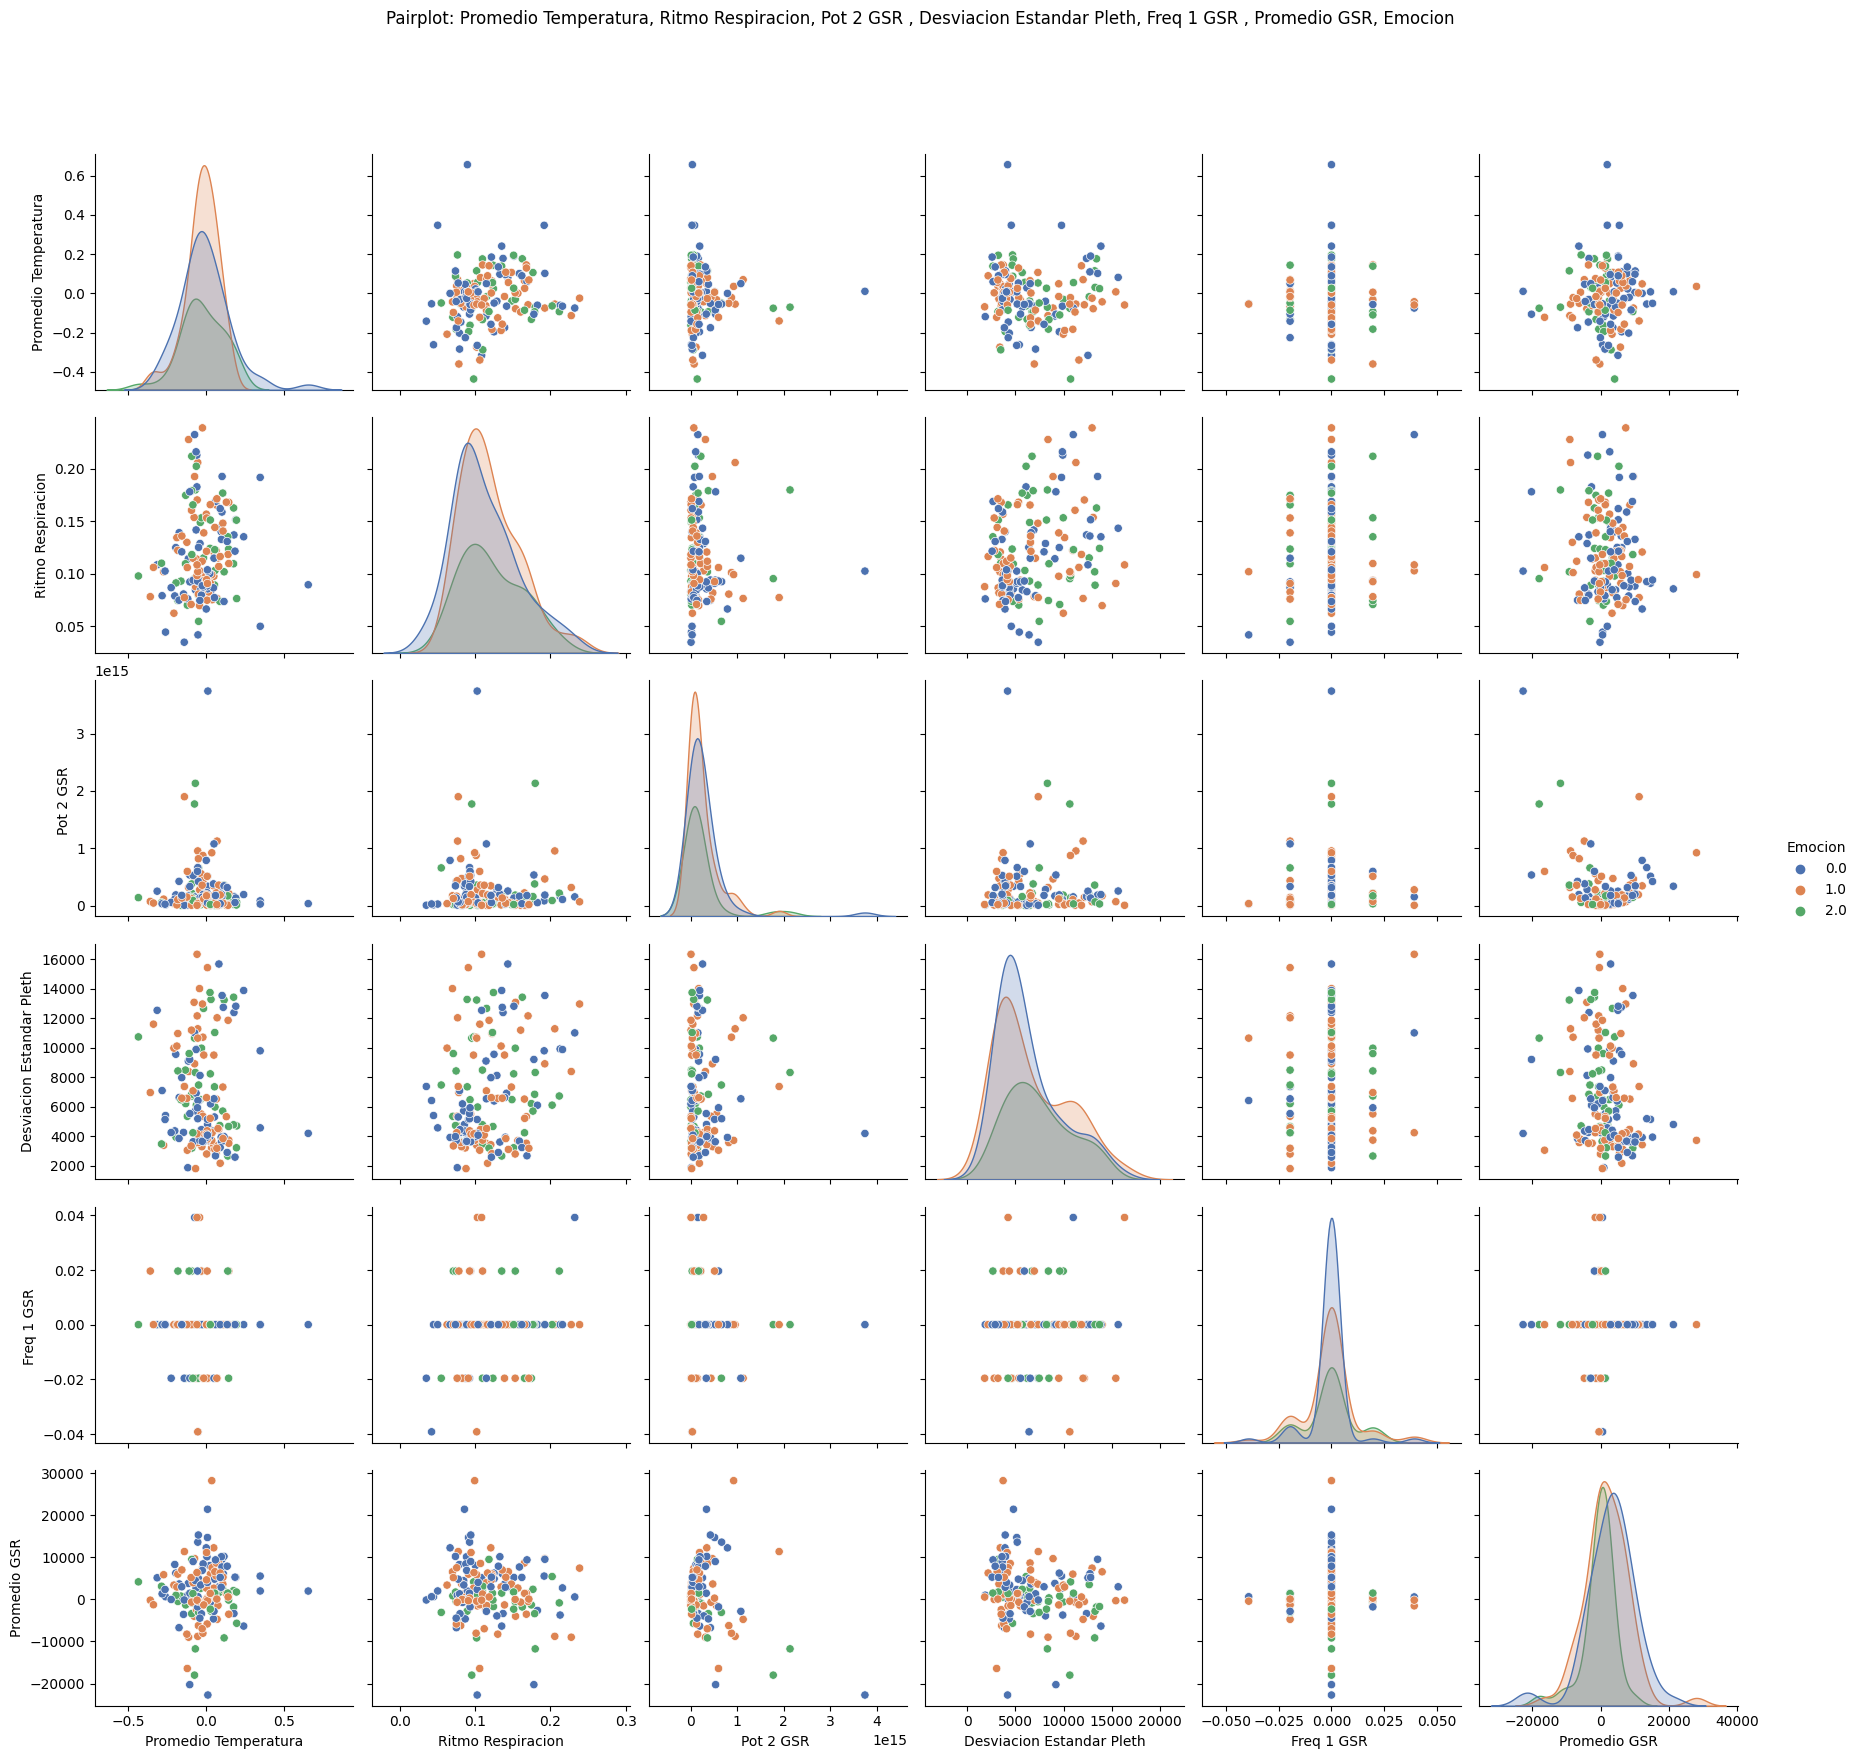

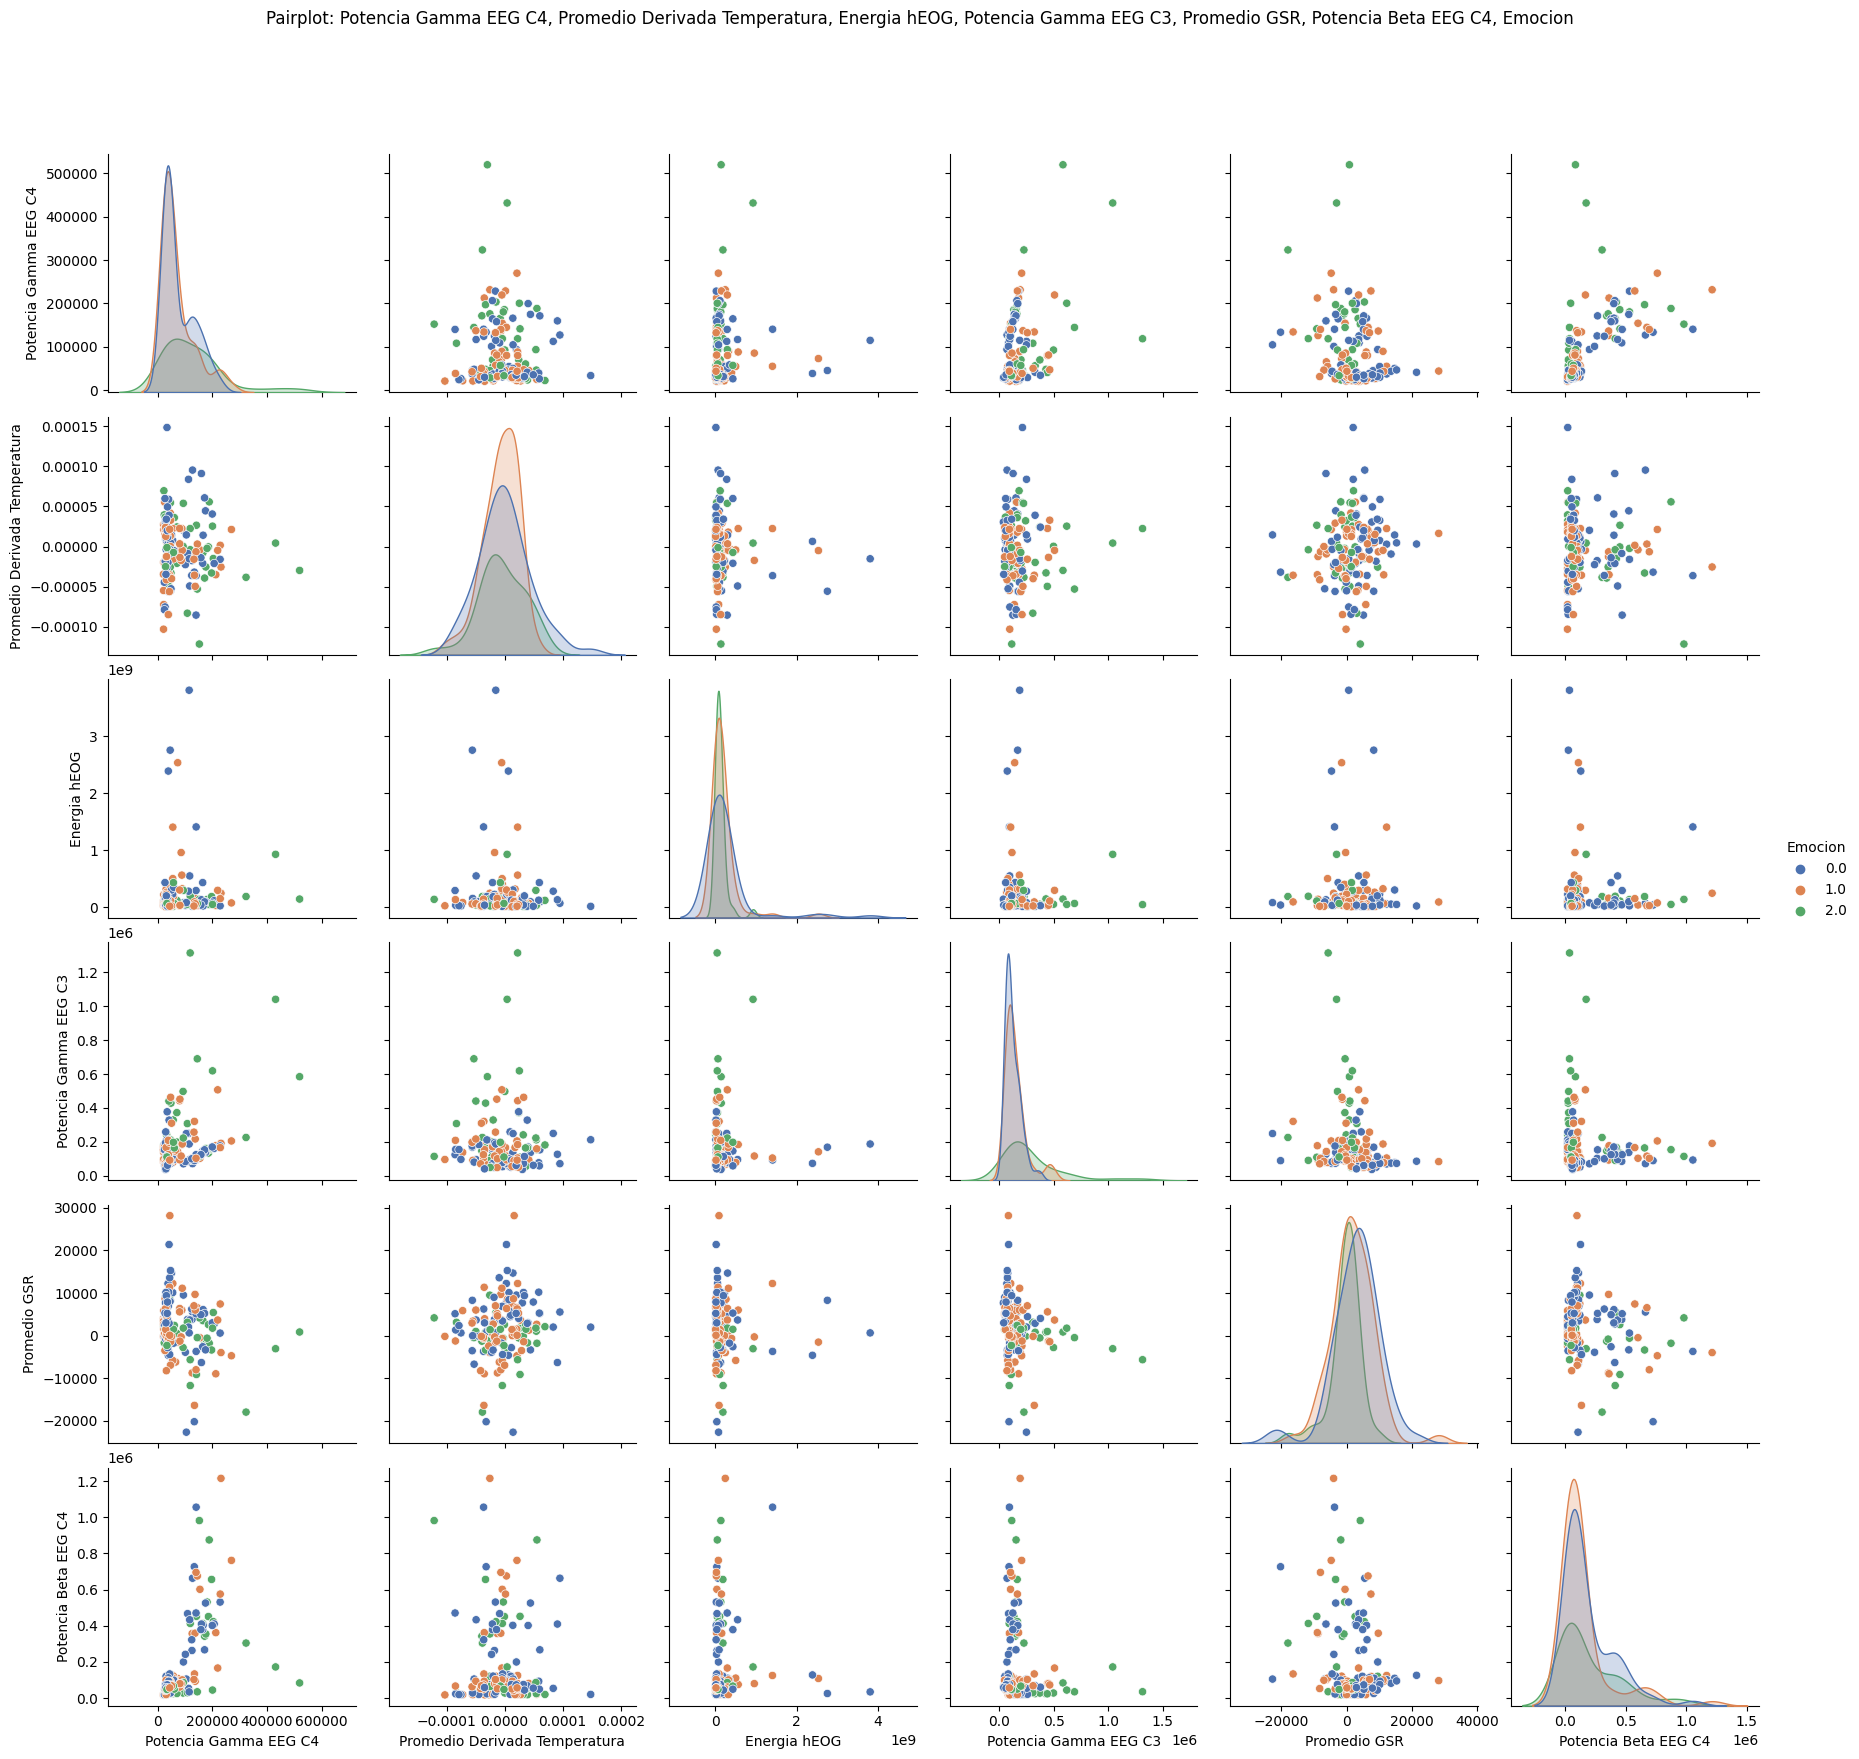

In [ ]:
import random
# Lista de todas las características disponibles
caracteristicas_disponibles = ['Promedio GSR','Minimos locales GSR','Pot 1 GSR ','Pot 2 GSR ','Pot 3 GSR ','Pot 4 GSR ','Pot 5 GSR ','Pot 6 GSR ','Pot 7 GSR ','Pot 8 GSR ','Pot 9 GSR ','Pot 10 GSR ','Freq 1 GSR ','Freq 2 GSR ','Freq 3 GSR ','Freq 4 GSR ','Freq 5 GSR ','Freq 6 GSR ','Freq 7 GSR ','Freq 8 GSR ','Freq 9 GSR ','Freq 10 GSR ','Media Pleth','Desviacion Estandar Pleth','Pot Pleth', 'HRV [seg]','Tasa Respiracion','Media Derivada Respiracion','Ritmo Respiracion','Promedio Temperatura','Promedio Derivada Temperatura','Potencia Espectral Temperatura','Energia hEOG','Energia vEOg','Media hEOG','Media vEOG','Varianza hEOG','Varianza vEOG','Tasa de parpadeo vEOG','Energia zEMG','Energia tEMG','Media zEMG','Media tEMG','Varianza zEMG','Varianza tEMG','Potencia Alpha EEG C3','Potencia Alpha EEG C4','Potencia Beta EEG C3','Potencia Beta EEG C4','Potencia Gamma EEG C3','Potencia Gamma EEG C4']
for i in range(5):
    # Seleccionar 6 características aleatorias
    caracteristicas_seleccionadas = random.sample(caracteristicas_disponibles, 6)

    # Asegurarse de que 'Emocion' esté presente en la lista seleccionada
    if 'Emocion' not in caracteristicas_seleccionadas:
        caracteristicas_seleccionadas.append('Emocion')

    # Crear un DataFrame con las características seleccionadas
    newDATA = dataFrame_Total.loc[:, caracteristicas_seleccionadas]

    # Configurar el tamaño del gráfico
    height = 3

    # Crear el pairplot
    pairplot = sns.pairplot(newDATA, hue='Emocion', height=height, palette="deep")
    # Agregar un título que identifique el conjunto de características
    title = ', '.join(caracteristicas_seleccionadas)
    plt.subplots_adjust(top=0.9)  # Ajustar el espacio para el título
    pairplot.fig.suptitle(f'Pairplot: {title}')

    # Mostrar el gráfico
    plt.show()

## Conclusiones y análisis

- Para evaluar la característica de la HRV, fue esencial realizar un análisis previo de las particularidades específicas de estas señales, como los picos que señalan las fluctuaciones en la presión sanguínea, así como el vector de tiempo correspondiente. Este enfoque permitió una definición precisa de la variabilidad de la frecuencia cardíaca y, en consecuencia, aumentó las posibilidades de obtener un análisis de las emociones que se acerque mucho más a situaciones de la vida real.

- Aunque normalizar o estandarizar las señales durante el preprocesamiento asegura la fidelidad de los datos con respecto a su forma original, en este caso no se consideró una opción viable para los objetivos de este miniproyecto. Esto se debe a que dichos procesos de normalización habrían reducido las características que podrían ser útiles para analizar las emociones inducidas por los videos utilizados en la experimentación.

- En las bibliotecas de Python, existen varios métodos de filtrado disponibles. En este contexto, se comenzó utilizando "lfilter" como una opción para analizar los espectros de potencia en distintas bandas de frecuencia. Sin embargo, los datos filtrados, en comparación con las otras características, mostraban valores significativamente más altos. Esto planteó dudas sobre su idoneidad para su inclusión en el modelo. Por lo tanto, se optó por implementar "sosfilt", un filtro de respuesta infinita de segundo orden, que arrojó resultados mucho mejores para el análisis del modelo.

- El hecho de obtener numerosas características de diversas señales no garantiza una predicción eficiente del modelo. Esto se debe a que los datos forman un conjunto de dimensiones considerables, representado como $N \times D$ (donde $N$ es el número de observaciones de señales captadas y $D$ es el número de características resultantes después del proceso de extracción). Esta dimensión es demasiado grande para reducirla a un análisis bidimensional (pairplots). Por lo tanto, la abundancia de características en las señales no es una condición suficiente. Es necesario aplicar diversas técnicas sobre estas características para lograr una predicción precisa de las emociones inducidas en los pacientes por cada video.

- Para las gráficas de pairplots, se consideró adecuado generar pares de características de manera aleatoria con el fin de analizar cuál conjunto de características era más apropiado para clasificar las emociones. Después de generar múltiples conjuntos de pairplots, se pudo concluir que ninguno de ellos proporcionaba información precisa que permitiera identificar las emociones.
